In [17]:
import os
import pandas as pd
import pickle
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt


In [55]:
path = "../Stempelliste_bueschel_Neuses_einfach.xlsx"
df = pd.read_excel(path, engine='openpyxl')

Averse = defaultdict(list)
Reverse = defaultdict(list)

ID = df["Dédalo ID"]
A = df["Stempeluntergruppe Av"]
R = df["Stempeluntergruppe Rv"]

for id_val, av, rv in zip(ID, A, R):
    Averse[av].append(id_val)
    Reverse[rv].append(id_val)

In [50]:
with open("Die_Ground_Truth.pkl", "wb") as f:
    pickle.dump({"Averse": dict(Averse), "Reverse": dict(Reverse)}, f)

## "Load Ground Truth and calculate random draws"

In [14]:

with open("Die_Ground_Truth.pkl", "rb") as f:
    truth = pickle.load(f)

Averse = [coin_id for group in truth["Averse"].values() for coin_id in group]
total = sum(len(v) for v in truth["Averse"].values())

relative_frequencies = {
    die: len(v) / total for die, v in truth["Averse"].items()
}

ground_truth = list(truth["Averse"].keys())


random_preds = np.random.choice(ground_truth, size=total, p=list(relative_frequencies.values()))
n = 0
result = {}
for i, pred in zip(Averse, random_preds):
    result[i] = pred


# Convert to DataFrame
df = pd.DataFrame(result.items(), columns=["ID", "Class"])

#df.to_excel("random_dist.xlsx", index=False)

    


In [15]:

comparision = []
for i in range(len(truth["Averse"].keys())):
    correct = 0
    false = 0
    for x in list(truth["Averse"].values())[i]:
        if result[x] == list(truth["Averse"].keys())[i]:
            correct += 1
        else:
            false += 1
    comparision.append([correct,false])
            
Distribution = []


for i, class_name in enumerate(truth["Averse"].keys()):
    counter = {}  # will hold predicted class counts for this true class

    # Get all coin IDs for this ground truth class
    ids = truth["Averse"][class_name]

    for x in ids:
        predicted_class = result.get(x, 'nan')
        if predicted_class in counter:
            counter[predicted_class] += 1
        else:
            counter[predicted_class] = 1

    Distribution.append(counter)

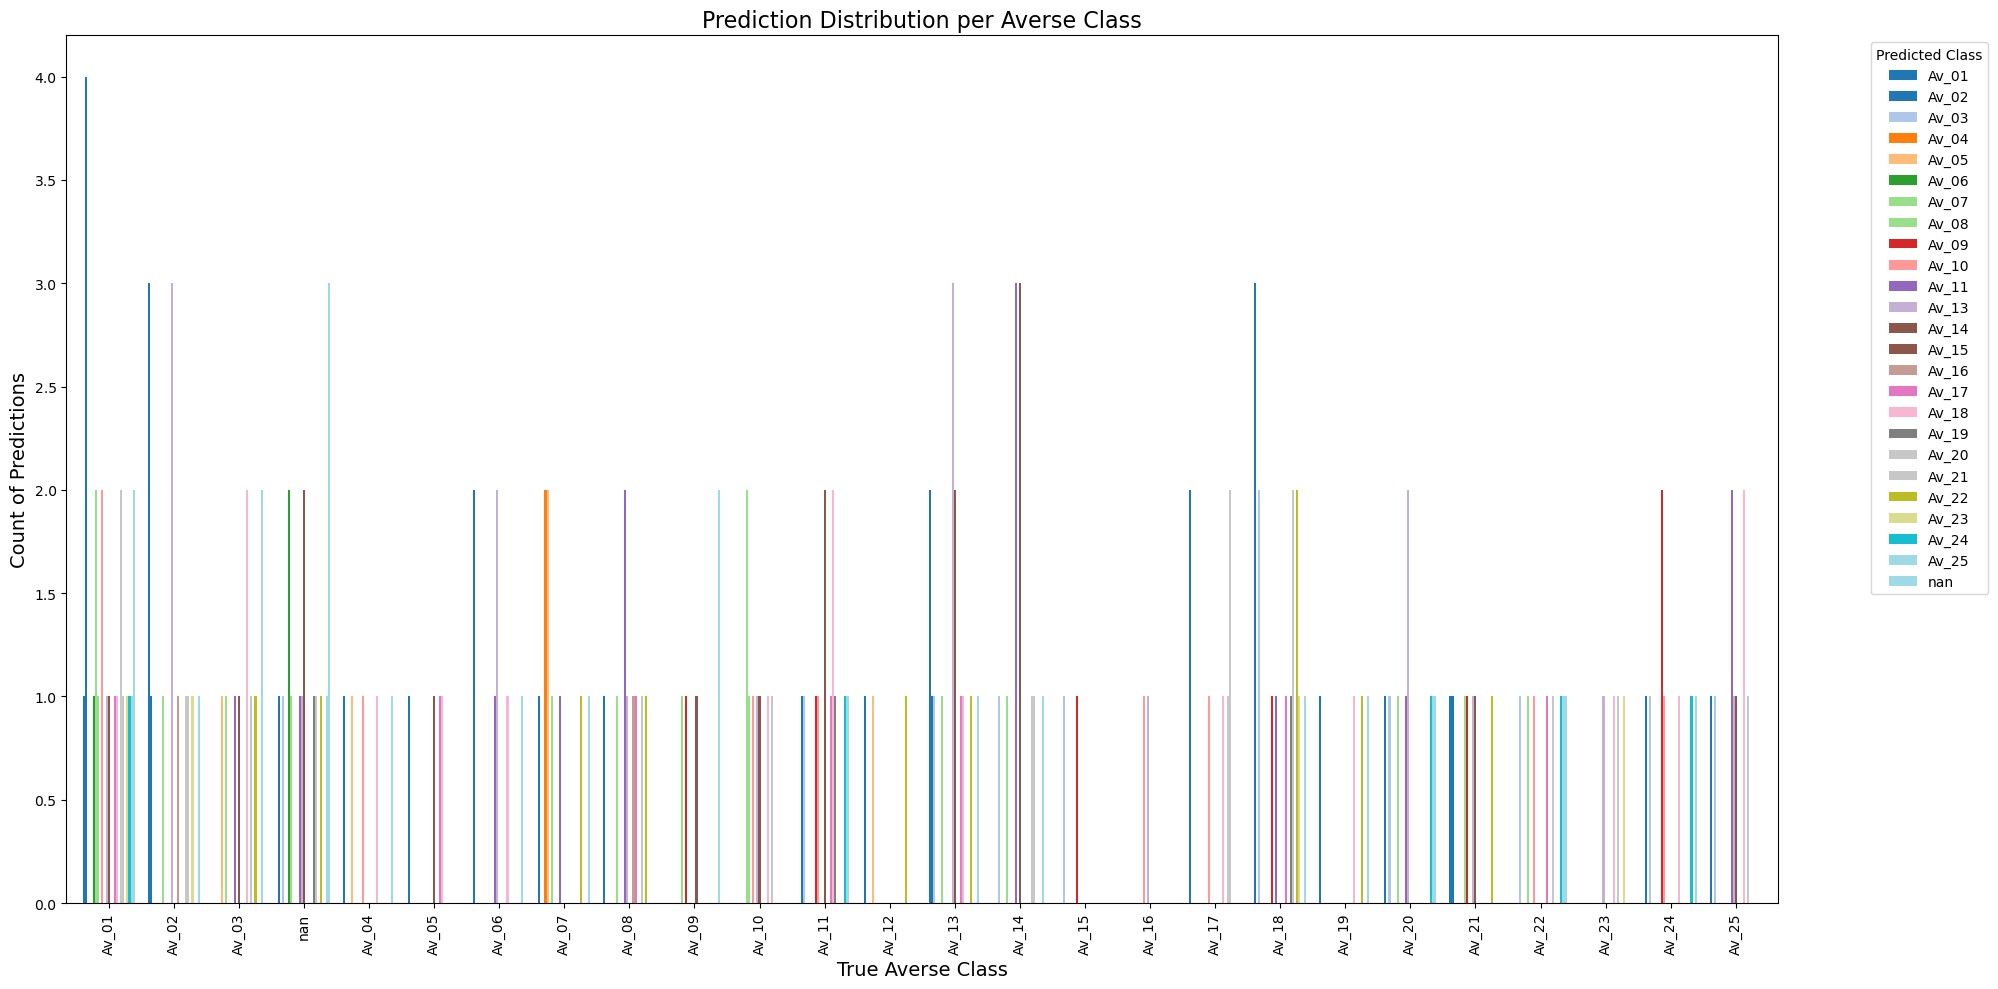

In [18]:
df = pd.DataFrame(Distribution).fillna(0).astype(int)
df.index = list(truth["Averse"].keys())  # Label rows by true class
df.columns.name = "Predicted Class"
df.index.name = "True Class"

# Ensure columns are sorted like Av_01, Av_02, ..., Av_25, nan
sorted_columns = sorted(df.columns, key=lambda x: (str(x) == 'nan', int(x.split('_')[1]) if x != 'nan' else 999))

# Reorder DataFrame columns
df_sorted = df[sorted_columns]

# Plot
df_sorted.plot(kind='bar', stacked=False, width=0.8, figsize=(20, 10), colormap='tab20')

plt.title("Prediction Distribution per Averse Class", fontsize=16)
plt.xlabel("True Averse Class", fontsize=14)
plt.ylabel("Count of Predictions", fontsize=14)
plt.legend(title="Predicted Class", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()